In [6]:
import matplotlib.pyplot as plt
from utils.test_utils import *
from utils.net_utils import *
import matplotlib.gridspec as gridspec
import torch
from unet import UNet
from hednet import HedNet
from IPython.display import clear_output
from PIL import Image
import plotly.graph_objects as go
from tabulate import tabulate
from utils.fiber_ec import fiber_ec
from utils.new_distance_transform import new_distance_transform
import pandas as pd
import cv2
import time, datetime

In [7]:
torch.cuda.empty_cache()

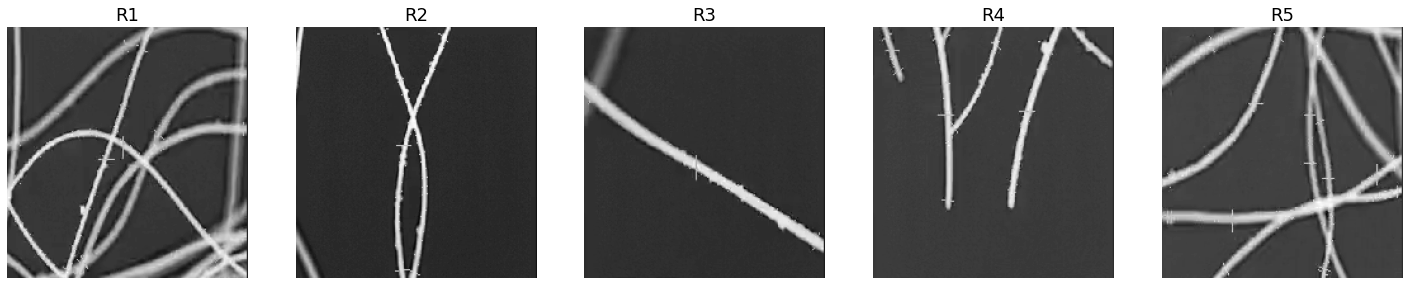

In [3]:
folder_path = 'data/ofda/raw'

plt.figure(figsize=(5*5,5))
k = 0
for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path,filename)
    if os.path.isfile(img_path):
        img = cv2.imread(img_path, 0)
        img = 255 - img
        plt.subplot(1,5,k+1), plt.axis('off'), plt.title(f'R{k+1}', fontdict = {'fontsize' : 18}), plt.imshow(img, cmap='gray')
        k=k+1
        
#plt.savefig('resultados/real.png', bbox_inches='tight')
plt.show()

In [8]:
# creando un batch
folder_path = 'data/ofda/images'

img_path_list = []
img_list = []
for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path,filename)
    if os.path.isfile(img_path):
        img_path_list.append(img_path)
        img = cv2.imread(img_path, 0)
        img_list.append(img)
        
tensor_batch = batch_from_folder(folder_path)

In [10]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

net = UNet(n_channels=3, n_classes=1, bilinear=False)
#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    net = nn.DataParallel(net)
net.to(device=device)

########
# state_dict = torch.load('checkpoints/MODEL_unet_sli.pth')
state_dict = torch.load('checkpoints/MODEL_dist_ours.pth')
from collections import OrderedDict
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
########

net.load_state_dict(new_state_dict)
net.eval()

clear_output()


# diameter_meas_unet = get_diameters(net, img_path_list, device)
prev_time = time.time()

dm_list_unet = predict_dm_list(net, {'image':tensor_batch}, device)

inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print(f'Inference Time: {inference_time}')

Inference Time: 0:00:00.064028


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = HedNet(n_channels=3, n_classes=1, bilinear=False, side=4)
#device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    net = nn.DataParallel(net)
net.to(device=device)

########
# state_dict = torch.load('checkpoints/MODEL_snet_sli.pth')
state_dict = torch.load('checkpoints/MODEL_snet_reg_ours.pth')
from collections import OrderedDict
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
########

net.load_state_dict(new_state_dict)
#net.load_state_dict(state_dict)
net.eval()

clear_output()

# print(type(tensor_batch))

prev_time = time.time()
# diameter_meas_snet = get_diameters(net, img_path_list, device)
dm_list_snet = predict_dm_list(net, {'image':tensor_batch}, device)

inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print(f'Inference Time: {inference_time}')

Inference Time: 0:00:00.283500


In [4]:
device = torch.device('cpu')

net = UNet(n_channels=3, n_classes=1, bilinear=False)
#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    net = nn.DataParallel(net)
# net.to(device=device)

########
# state_dict = torch.load('checkpoints/MODEL_unet_sli.pth')
state_dict = torch.load('checkpoints/MODEL_dist_ours.pth', map_location=device)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
########

net.load_state_dict(new_state_dict)
net.eval()

clear_output()


prev_time = time.time()

with torch.no_grad():
    tensor_batch = tensor_batch.to(device)
    output = net(tensor_batch)
predictions = output.cpu().numpy()
dm_list = [predictions[i].squeeze() for i in range(predictions.shape[0])]

inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print(f'Inference Time UNet: {inference_time}')

Inference Time UNet: 0:00:19.346518


In [5]:
device = torch.device('cpu')

net = HedNet(n_channels=3, n_classes=1, bilinear=False, side=4, use_cuda=False)
#device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    net = nn.DataParallel(net)
# net.to(device=device)

########
# state_dict = torch.load('checkpoints/MODEL_snet_sli.pth')
state_dict = torch.load('checkpoints/MODEL_snet_reg_ours.pth', map_location=device)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
########

net.load_state_dict(new_state_dict)
#net.load_state_dict(state_dict)
net.eval()

clear_output()

# print(type(tensor_batch))

prev_time = time.time()
# diameter_meas_snet = get_diameters(net, img_path_list, device)
# dm_list_snet = predict_dm_list(net, {'image':tensor_batch}, None)

with torch.no_grad():
#     imgs = batch['image'] if device is None else batch['image'].to(device)
    tensor_batch = tensor_batch.to(device)
    output = net(tensor_batch)
predictions = output.cpu().numpy()
dm_list = [predictions[i].squeeze() for i in range(predictions.shape[0])]

inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print(f'Inference Time: {inference_time}')

Inference Time: 0:02:41.893243


data/ofda/images/bin_0214.png


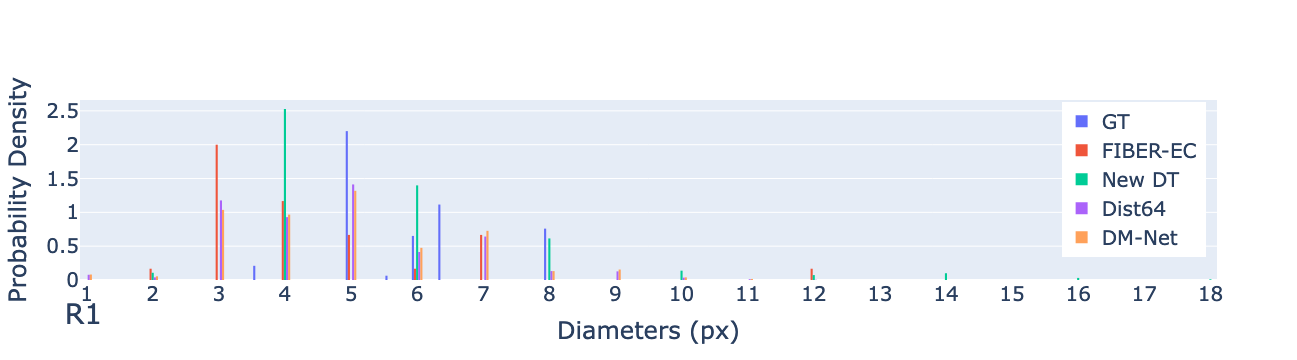

data/ofda/images/bin_0199.png


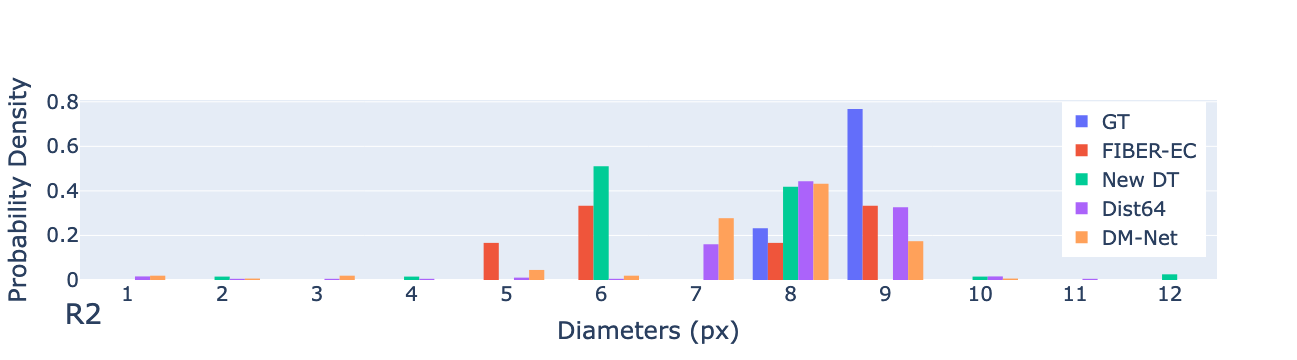

data/ofda/images/bin_0157.png


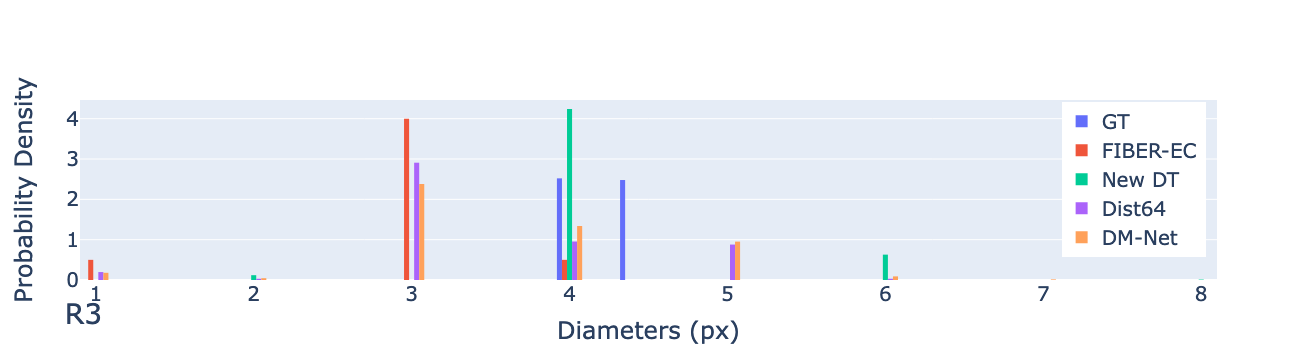

data/ofda/images/bin_0200.png


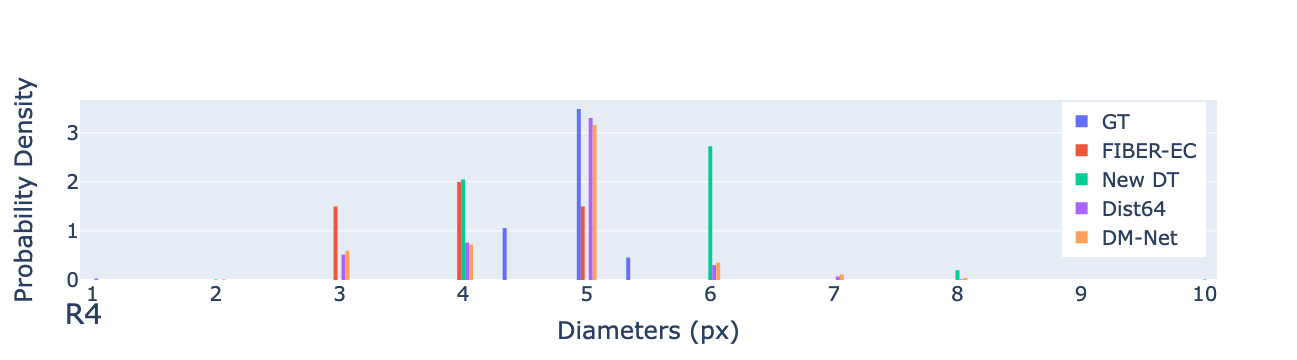

data/ofda/images/bin_0225.png


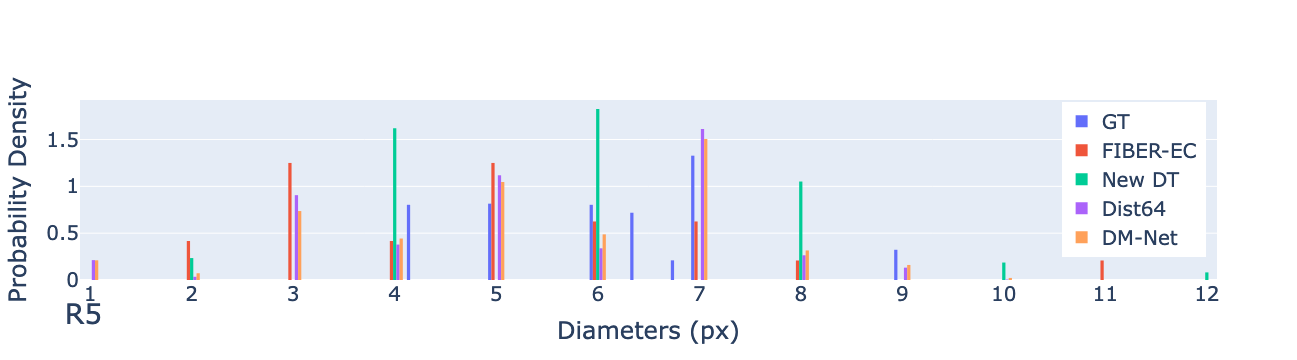

In [7]:
gt_means = []
gt_stds = []

means_fec = []
stds_fec = []

means_ndt = []
stds_ndt = []

diameter_means_unet = []
stds_dist = []

diameter_means_snet = []
stds_dmnet = []

error_fec = []
error_ndt = []
error_dist = []
error_dmnet = []

for i,img_path in enumerate(img_path_list):
    
    print(img_path)
    # GT
    diameter_count = gt_ofda_diameter_count(img_path)
    mean = get_mean_diameter(diameter_count)
    std = get_std(diameter_count)
    gt_means.append(mean)
    gt_stds.append(std)
    d0 = [k for k,v in diameter_count.items() for j in range(int(v))]    
    
    # FIBER-EC
    diameter_count = fiber_ec(img_path)
    d1 = [k for k,v in diameter_count.items() for j in range(int(v))]
    mean = get_mean_diameter(diameter_count)
    means_fec.append(mean)
    std = get_std(diameter_count)
    stds_fec.append(std)
    error_fec.append(abs(mean - gt_means[i]))
    
    # New DT
    diameter_count = new_distance_transform(img_path)
    d2 = [k for k,v in diameter_count.items() for j in range(int(v))]
    mean = get_mean_diameter(diameter_count)
    means_ndt.append(mean)
    std = get_std(diameter_count)
    stds_ndt.append(std)
    error_ndt.append(abs(mean - gt_means[i]))
    
    # DIST64
    diameter_count = get_diameter_count(dm_list_unet[i])
    # mean
    diameter_mean = calc_diameter_mean(diameter_count)
    diameter_means_unet.append(diameter_mean)
    # histogram
    d3 = [k for k,v in diameter_count.items() for j in range(int(v))]
    # std
    std = get_std(diameter_count)
    stds_dist.append(std)
    error_dist.append(abs(diameter_mean - gt_means[i]))

    # DM-NET
    diameter_count = get_diameter_count(dm_list_snet[i])
    # mean
    diameter_mean = calc_diameter_mean(diameter_count)
    diameter_means_snet.append(diameter_mean)
    # histogram
    d4 = [k for k,v in diameter_count.items() for j in range(int(v))]
    # std
    std = get_std(diameter_count)
    stds_dmnet.append(std)
    error_dmnet.append(abs(diameter_mean - gt_means[i]))

    #histograma
    fig = go.Figure(data=[
        go.Histogram(x=d0, histnorm='probability density', name='GT'),        
        go.Histogram(x=d1, histnorm='probability density', name='FIBER-EC'),
        go.Histogram(x=d2, histnorm='probability density', name='New DT'),
        go.Histogram(x=d3, histnorm='probability density', name='Dist64'),
        go.Histogram(x=d4, histnorm='probability density', name='DM-Net'),
    ])
    fig.update_layout(
        xaxis=dict(tickmode='linear',title='Diameters (px)'),
        yaxis=dict(title='Probability Density'),
        title={'text':f'R{i+1}','y':0.1},
        legend=dict(yanchor='top',y=0.99,xanchor='right',x=0.99),
        font=dict(size=20)
    )
    fig.write_image(f"resultados/histograma_r{i+1}.png")
    fig.show()

In [8]:
report = {
    'Sample': [f'I{i+1}' for i in range(5)],
    'GT - Mean': gt_means,
    'GT - Std': gt_stds,
    'FIBER-EC - Mean': means_fec,
    'FIBER-EC - Std': stds_fec,
    'New DT - Mean': means_ndt,
    'New DT - Std': stds_ndt,
    'U-Net - Mean': diameter_means_unet,
    'U-Net - Std': stds_dist,
    'SkeletonNet - Mean': diameter_means_snet,
    'SkeletonNet - Std': stds_dmnet
}

print(tabulate(report, headers='keys', tablefmt='simple', floatfmt='.3f'))

Sample      GT - Mean    GT - Std    FIBER-EC - Mean    FIBER-EC - Std    New DT - Mean    New DT - Std    U-Net - Mean    U-Net - Std    SkeletonNet - Mean    SkeletonNet - Std
--------  -----------  ----------  -----------------  ----------------  ---------------  --------------  --------------  -------------  --------------------  -------------------
I1              5.848       1.141              4.400             1.993            5.594           2.420           4.834          1.719                 4.940                1.758
I2              8.768       0.422              7.167             1.572            6.959           1.491           7.979          1.383                 7.465                1.529
I3              4.233       0.235              2.900             0.700            4.213           0.767           3.476          0.941                 3.634                0.994
I4              4.923       0.260              4.000             0.775            5.260           1.151       

In [9]:
print(tabulate(report, headers='keys', tablefmt='latex', floatfmt='.3f'))

\begin{tabular}{lrrrrrrrrrr}
\hline
 Sample   &   GT - Mean &   GT - Std &   FIBER-EC - Mean &   FIBER-EC - Std &   New DT - Mean &   New DT - Std &   U-Net - Mean &   U-Net - Std &   SkeletonNet - Mean &   SkeletonNet - Std \\
\hline
 I1       &       5.848 &      1.141 &             4.400 &            1.993 &           5.594 &          2.420 &          4.834 &         1.719 &                4.940 &               1.758 \\
 I2       &       8.768 &      0.422 &             7.167 &            1.572 &           6.959 &          1.491 &          7.979 &         1.383 &                7.465 &               1.529 \\
 I3       &       4.233 &      0.235 &             2.900 &            0.700 &           4.213 &          0.767 &          3.476 &         0.941 &                3.634 &               0.994 \\
 I4       &       4.923 &      0.260 &             4.000 &            0.775 &           5.260 &          1.151 &          4.715 &         0.850 &                4.751 &               0.906 

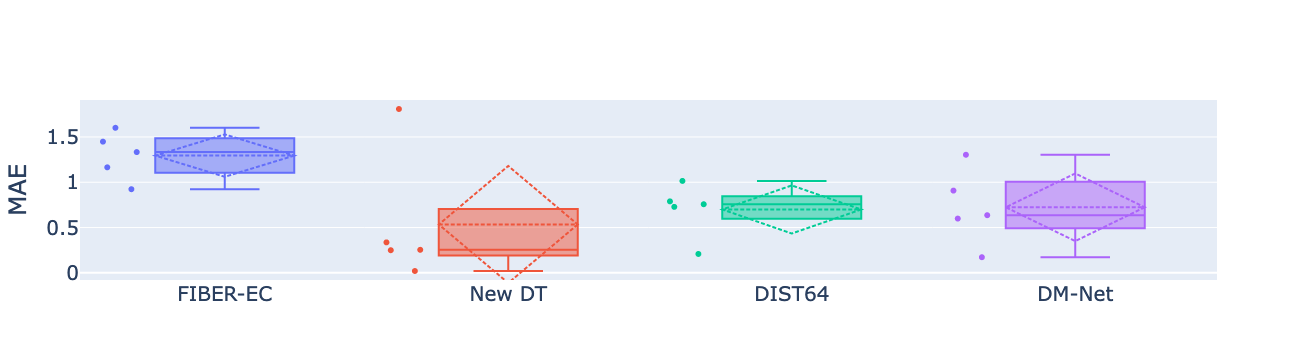

In [10]:
fig = go.Figure()
fig.add_trace(go.Box(y=error_fec,name='FIBER-EC'))
fig.add_trace(go.Box(y=error_ndt,name='New DT'))
fig.add_trace(go.Box(y=error_dist,name='DIST64'))
fig.add_trace(go.Box(y=error_dmnet,name='DM-Net'))
fig.update_traces(boxpoints='all',showlegend=False,boxmean='sd')
fig.update_layout(yaxis_title='MAE', font=dict(size=20))
fig.write_image(f"resultados/boxplot-real.png")
fig.show()

In [12]:
# creamos una matriz de los errores de medicion
errors = np.zeros((5,4))

errors[:,0] = np.array(error_fec)
errors[:,1] = np.array(error_ndt)
errors[:,2] = np.array(error_dist)
errors[:,3] = np.array(error_dmnet)

# media del error de medición
mae = np.mean(errors, axis=0)

# MSE de la medición
mse = np.square(errors).mean(axis=0)

# desviación estándar del error de medición
std = np.std(errors, axis=0)

dataset = {
    'Method':['FIBER-EC','New DT','DIST64','DM-Net'],
    'MAE': mae.tolist(),
    'Std': std.tolist(),
    'MSE': mse.tolist(),
}

print(tabulate(dataset, headers='keys', tablefmt='psql', floatfmt='.3f'))

+----------+-------+-------+-------+
| Method   |   MAE |   Std |   MSE |
|----------+-------+-------+-------|
| FIBER-EC | 1.294 | 0.234 | 1.729 |
| New DT   | 0.534 | 0.646 | 0.702 |
| DIST64   | 0.700 | 0.265 | 0.560 |
| DM-Net   | 0.724 | 0.373 | 0.663 |
+----------+-------+-------+-------+


In [14]:
print(tabulate(dataset, headers='keys', tablefmt='latex', floatfmt='.3f'))

\begin{tabular}{lrrr}
\hline
 Method   &   MAE &   Std &   MSE \\
\hline
 FIBER-EC & 1.294 & 0.234 & 1.729 \\
 New DT   & 0.534 & 0.646 & 0.702 \\
 DIST64   & 0.700 & 0.265 & 0.560 \\
 DM-Net   & 0.724 & 0.373 & 0.663 \\
\hline
\end{tabular}


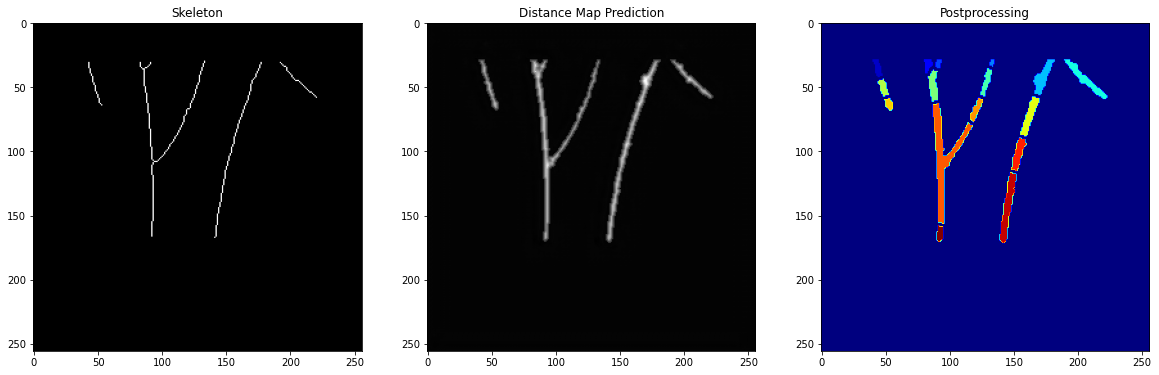

In [14]:
index = 3

distance_map = dm_list_unet[index]

# for dm in dm_list_snet:
#     plt.imshow(dm, cmap='gray')
#     plt.show()

# normalizar solo para sacar segmentos
dm_normalized = cv2.normalize(distance_map, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
segmentos = PostProcess(dm_normalized, 40, 32)

img_skeleton = morphology.skeletonize(img_list[index], method='lee')
pil_img = Image.fromarray(img_skeleton)
diffX = 256 - pil_img.size[0]            
diffY = 256 - pil_img.size[1]
pil_img = add_margin(pil_img, diffY // 2, diffX - diffX//2, diffY - diffY//2, diffX // 2, 0)
img_skeleton = np.asarray(pil_img)


plt.figure(figsize=(20,20))
plt.subplot(1,3,1), plt.title('Skeleton'), plt.imshow(img_skeleton, cmap='gray')
plt.subplot(1,3,2), plt.title('Distance Map Prediction'), plt.imshow(distance_map, cmap='gray')
plt.subplot(1,3,3), plt.title('Postprocessing'), plt.imshow(segmentos, cmap='jet')
plt.show()

In [15]:
diametros = {}
# segmento = (segmentos==1)
# seg_skeleton = img_skeleton[segmento>0]
#seg_skeleton.shape
# plt.imshow(np.bitwise_and(img_skeleton, segmento), cmap='gray')

# recorrer todos los segmentos detectados:
for i in range(0, segmentos.max()):
    # obtenemos el segmento actual:
    segmento = (segmentos==i+1)
    # obtenemos el skeleton del segmento:
#     seg_skeleton = morphology.skeletonize(segmento, method='lee')
    seg_skeleton = np.bitwise_and(img_skeleton, segmento)
    # obtenemos sus diametros desde el mapa de distancia:
    seg_diametros = np.floor(distance_map[seg_skeleton>0]*2)
    # contamos los diametros:
    unique, counts = np.unique(seg_diametros, return_counts=True)
    seg_diametros_count = dict(zip(unique, counts))
    # juntamos los diametros:
    for k,v in seg_diametros_count.items():
        diametros[k] = diametros.get(k,0) + v
        
mean = get_mean_diameter(diametros)

print('mean:', mean)

mean: 4.6938775510204085


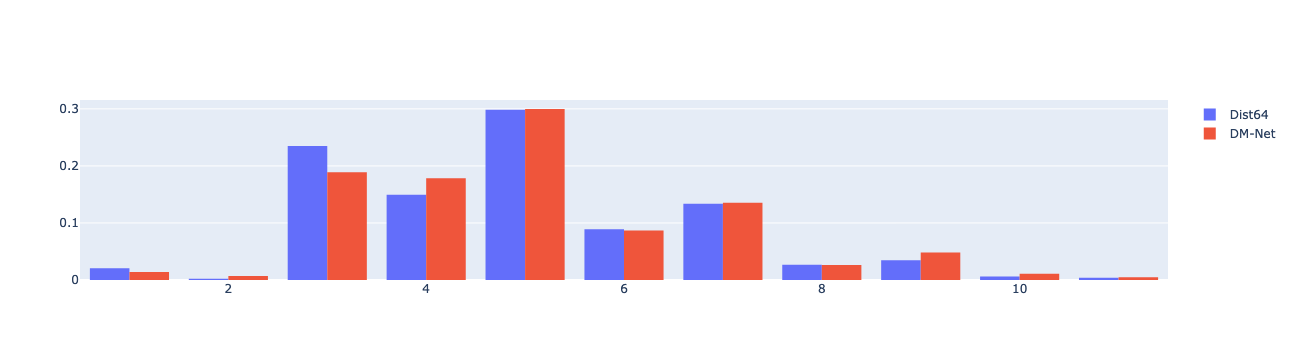

In [11]:
# densidad de diametros obtenidos

diameter_count = get_diameter_count(dm_list_unet[0])
d1 = [k for k,v in diameter_count.items() for i in range(int(v))]

diameter_count = get_diameter_count(dm_list_snet[0])
d2 = [k for k,v in diameter_count.items() for i in range(int(v))]

fig = go.Figure(data=[
    go.Histogram(x=d1, histnorm='probability density', name='Dist64'),
    go.Histogram(x=d2, histnorm='probability density', name='DM-Net'),
])
fig.show()

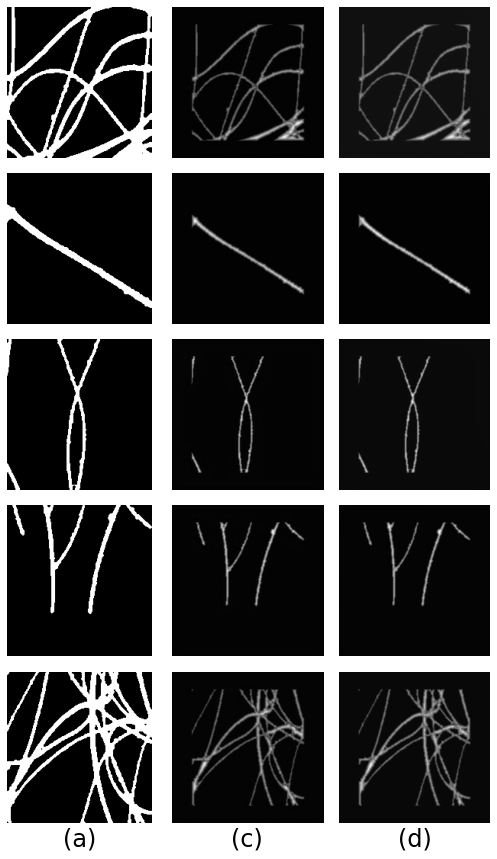

In [5]:
plt.figure(figsize=(3*3,5*3))

gs = gridspec.GridSpec(5, 3)
gs.update(wspace=0, hspace=0.1)
k = 0
for i in range(5):
#     image = make_grid(lote['image'][:5][i], nrow=1, padding=0, normalize=True)
# #     mask = make_grid(lote['mask'][:5][i], nrow=1, padding=0, normalize=True)
#     unet = make_grid(dm_tensores_unet[:5][i], nrow=1, padding=0, normalize=True)
#     snet = make_grid(dm_tensores_snet[:5][i], nrow=1, padding=0, normalize=True)
    
    image = image_list[i]
    dm_dist = dm_dist_list[i]
    dm_dmnet = dm_dmnet_list[i]
    
    plt.subplot(gs[k]), plt.axis('off')
    if i==4: 
        plt.title('(a)', y=-0.2, fontdict = {'fontsize' : 24})
    plt.imshow(image, cmap='gray')
    
#     plt.subplot(gs[k+1]), plt.axis('off')
#     if i==4: 
#         plt.title('(b)', y=-0.2, fontdict = {'fontsize' : 24})
#     plt.imshow(mask.permute(1,2,0))
    
    plt.subplot(gs[k+1]), plt.axis('off')
    if i==4: 
        plt.title('(c)', y=-0.2, fontdict = {'fontsize' : 24})
    plt.imshow(dm_dist, cmap='gray')
    
    plt.subplot(gs[k+2]), plt.axis('off')
    if i==4:
        plt.title('(d)', y=-0.2, fontdict = {'fontsize' : 24})
    plt.imshow(dm_dmnet, cmap='gray')
    
    k += 3

plt.savefig('resultados/grid_real.png', bbox_inches='tight')
plt.show()

In [ ]:
# buscando error de prediccion en otras dimensiones de la imagen

net = HedNet(n_channels=3, n_classes=1, bilinear=False, side=4)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     net = nn.DataParallel(net)
net.to(device=device)

########
# state_dict = torch.load('checkpoints/MODEL_snet_sli.pth')
state_dict = torch.load('checkpoints/MODEL_snet_reg_ours.pth')
from collections import OrderedDict
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
########

net.load_state_dict(new_state_dict)
net.eval()

clear_output()

RuntimeError: Error(s) in loading state_dict for HedNet:
	Missing key(s) in state_dict: "upso1.up.weight", "upso1.up.bias", "upso2.up.weight", "upso2.up.bias", "upso3.up.weight", "upso3.up.bias", "upso4.up.weight", "upso4.up.bias". 
	Unexpected key(s) in state_dict: "upso1.weight", "upso1.bias", "upso2.weight", "upso2.bias", "upso3.weight", "upso3.bias", "upso4.weight", "upso4.bias". 

In [ ]:
net = HedNet(n_channels=3, n_classes=1, bilinear=False, side=4)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device=device)

clear_output()

In [6]:
#from torchsummary import summary
from pytorch_model_summary import summary


# summary(net, (3,256,256))

print(summary(net, torch.zeros((1, 3, 190, 198)), show_input=False))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
     CoordConv2d-1     [1, 64, 190, 198]             640             640
      DoubleConv-2     [1, 64, 190, 198]         230,080         230,080
            Down-3      [1, 128, 95, 99]         771,328         771,328
            Down-4      [1, 256, 47, 49]       3,082,752       3,082,752
            Down-5      [1, 512, 23, 24]      12,325,888      12,325,888
            Down-6     [1, 1024, 11, 12]      49,293,312      49,293,312
      DoubleConv-7     [1, 2048, 11, 12]     197,152,768     197,152,768
              Up-8      [1, 512, 23, 24]      28,842,242      28,842,242
              Up-9      [1, 256, 47, 49]       5,115,010       5,115,010
             Up-10      [1, 128, 95, 99]       1,279,554       1,279,554
             Up-11     [1, 64, 190, 198]         320,290         320,290
         UpSide-12      [1, 1, 190, 198]          